## Preprocesamiento del dataset de entrenamiento

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Reproducibilidad de resultados
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
dftrain = pd.read_csv("datasets/legitimate_train.csv") 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10924\1152367772.py:1: DtypeWarning: Columns (21,23,34,42,45,52) have mixed types. Specify dtype option on import or set low_memory=False.
  dftrain = pd.read_csv("datasets/legitimate_train.csv")


In [3]:
# Contar los valores menores a X en la columna "tcp.time_delta"
print((dftrain['tcp.time_delta'] < 0.001).sum())

# Filtrar las filas donde "tcp.time_delta" es mayor o igual a X
dftrain = dftrain.loc[dftrain['tcp.time_delta'] >= 0.001]

2078


In [4]:
# Lista de columnas a mantener
columns_to_keep = [
    "tcp.len", "tcp.stream", "tcp.flags", "tcp.time_delta"
]

# Mantiene las columnas especificadas
dftrain = dftrain[columns_to_keep]

In [5]:
pd.set_option('display.max_rows', None)
dftrain.head(3)

,tcp.len,tcp.stream,tcp.flags,tcp.time_delta
2,0,0,16,0.005308
3,53,0,24,0.001768
5,30,0,24,0.007080


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Create and fit an scaler
#scaler = StandardScaler() # Utilizando estandarizacion da mejores resultados
scaler = MinMaxScaler()
scaler.fit(dftrain)

# Ajustar el escalador a los datos de entrenamiento y transformarlos
dftrain = scaler.transform(dftrain)
print(dftrain[:3])
print(dftrain.dtype)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.45557219e-04]
 [8.54838710e-01 0.00000000e+00 1.00000000e+00 6.16035154e-05]
 [4.83870968e-01 0.00000000e+00 1.00000000e+00 4.87694497e-04]]
float64


In [7]:
import joblib

# Guardar el objeto scaler en un archivo
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [8]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_valid = train_test_split(dftrain, test_size=0.2)

## Modelo

In [9]:
# Model

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Crear un autoencoder con X capas
input_dim = dftrain.shape[1]  # Dimensión de entrada
latent_dim = 4  # Dimensión del vector latente

# Encoder
encoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(latent_dim, activation='relu', kernel_regularizer=l2(1e-6))  # Capa latente con weight decay
])

# Decoder
decoder = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')  # Capa de salida
])

# Autoencoder
autoencoder = keras.Sequential([encoder, decoder])

In [10]:
# Compilar el autoencoder
optimizer = Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [11]:
# Entrenar el autoencoder
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=512, verbose=1, validation_data=(X_valid, X_valid))

Epoch 1/10
117/117 [==============================] - 2s 4ms/step - loss: 0.0933 - val_loss: 0.0306
Epoch 2/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0203 - val_loss: 0.0114
Epoch 3/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 4/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 6/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 7/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 8/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/10
117/117 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0048

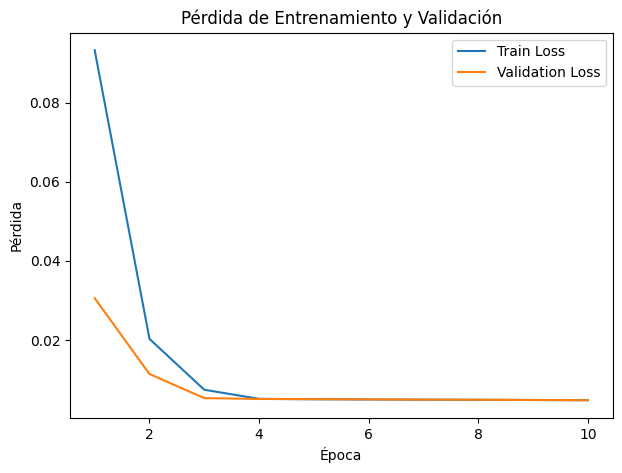

In [12]:
import matplotlib.pyplot as plt

# Obtener los valores de pérdida de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de pérdida de entrenamiento y pérdida de validación
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.show()

## Obtención del umbral

In [13]:
# Calcular las reconstrucciones para todos los datos
reconstrucciones_train = autoencoder.predict(X_train)

# Calcular el error de reconstrucción para todos los datos
errores_train = np.mean(np.square(reconstrucciones_train - X_train), axis=1)

# Establecer umbral para la detección de anomalías
umbral = np.mean(errores_train) + np.std(errores_train)
print("Umbral: ", umbral)
umbral = 0.02 # Se utiliza este umbral para mejores resultados

1868/1868 [==============================] - 2s 1ms/step
Umbral:  0.013805986838735542


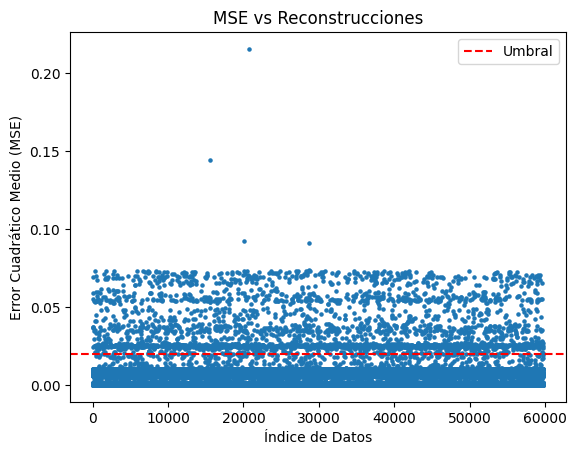

In [14]:
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión del MSE versus las reconstrucciones
plt.scatter(range(len(errores_train)), errores_train, s=5)  # s es el tamaño de los puntos

# Dibujar una línea horizontal en el umbral
plt.axhline(y=umbral, color='r', linestyle='--', label='Umbral')

# Etiquetas y título del gráfico
plt.xlabel('Índice de Datos')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE vs Reconstrucciones')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [15]:
# Contar las reconstrucciones mayores al umbral
mayores_umbral = np.sum(errores_train >= umbral)

# Contar las reconstrucciones menores al umbral
menores_umbral = np.sum(errores_train < umbral)

print("Reconstrucciones mayores al umbral:", mayores_umbral)
print("Reconstrucciones menores al umbral:", menores_umbral)

Reconstrucciones mayores al umbral: 2888
Reconstrucciones menores al umbral: 56887


## Preprocesamiento del dataset de prueba

In [16]:
import pandas as pd
import numpy as np

In [17]:
dftest = pd.read_csv("datasets/bruteforce.csv")

# Reemplazar valores diferentes de "legitimate" en la columna "feature" por "ataque"
dftest['target'] = dftest['target'].apply(lambda x: 'ataque' if x != 'legitimate' else x)

ataque_ = 'ataque'
dftest = dftest[dftest['target'].isin([ataque_, 'legitimate'])]

In [18]:
# Seleccionar de la fila X a la Y
#dftest = dftest.iloc[0:9000]
#dftest.reset_index(drop=True, inplace=True)

In [19]:
# Aplicar la condición y actualizar los valores
dftest.loc[dftest['tcp.time_delta'] < 0.001, 'tcp.time_delta'] = 10

In [20]:
# Lista de columnas a mantener
columns_to_keep = [
    "tcp.len", "tcp.stream", "tcp.flags", "tcp.time_delta", "target"
]

# Mantiene las columnas especificadas
dftest = dftest[columns_to_keep]

In [21]:
dftest.head(3)

,tcp.len,tcp.stream,tcp.flags,tcp.time_delta,target
0,0,0,2,10.00000,ataque
1,0,0,18,10.00000,ataque
2,0,0,16,0.00296,ataque


In [22]:
from sklearn.preprocessing import StandardScaler

# Separar la columna "target"
target_column = dftest['target']
dftest = dftest.drop(columns=['target'])

# Ajustar el escalador a los datos de prueba y transformarlos
dftest_normalized = scaler.transform(dftest)

# Convertir los datos normalizados en un DataFrame
dftest_normalized = pd.DataFrame(dftest_normalized, columns=dftest.columns)

# Volver a agregar la columna "target"
dftest_normalized['target'] = target_column

# Convertir el DataFrame a un arreglo NumPy
dftest = dftest_normalized.to_numpy()
print(dftest[:3])

[[0.0 0.0 -1.75 0.8020488944214407 'ataque']
 [0.0 0.0 0.25 0.8020488944214407 'ataque']
 [0.0 0.0 0.0 0.00015721730503710606 'ataque']]


## Evaluación

In [23]:
# Función para detectar anomalías
def detectar_anomalias(nuevo_dato):
    representacion_latente = autoencoder.layers[0](nuevo_dato)
    reconstruccion = autoencoder.layers[1](representacion_latente)
    error = np.mean(np.square(reconstruccion - nuevo_dato))
    
    if error > umbral:
        return ataque_, reconstruccion, error
    else:
        return "legitimate", reconstruccion, error

# Crear listas para almacenar las etiquetas reales y predichas, reconstrucciones y errores
etiquetas_reales = []
etiquetas_predichas = []
reconstrucciones_test = []
errores_test = []

# Prueba con un nuevo dato
for i in range(len(dftest)):
    nuevo_dato = dftest[i, :-1].astype(np.float64).reshape(1, -1)
    resultado, reconstruccion, error = detectar_anomalias(nuevo_dato)
    etiqueta = dftest[i, -1]
    #print(f"Valor {i}: - Etiqueta Real: {etiqueta} - Resultado: {resultado}")

    # Agregar las etiquetas reales, predichas, reconstrucciones y errores a las listas
    etiquetas_reales.append(etiqueta)
    etiquetas_predichas.append(resultado)
    reconstrucciones_test.append(reconstruccion)
    errores_test.append(error)

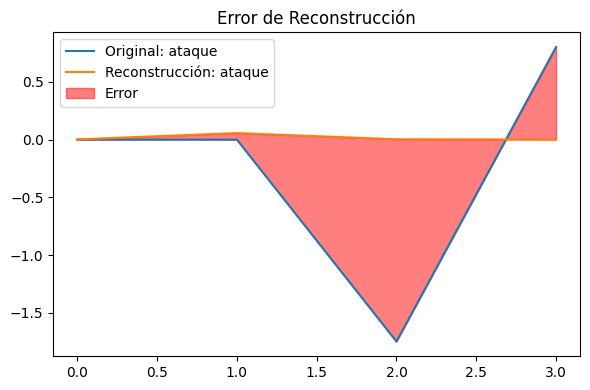

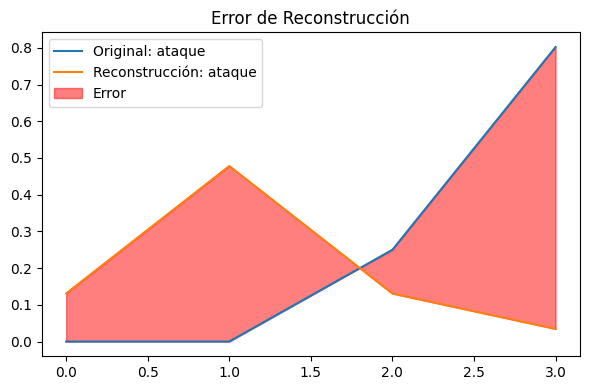

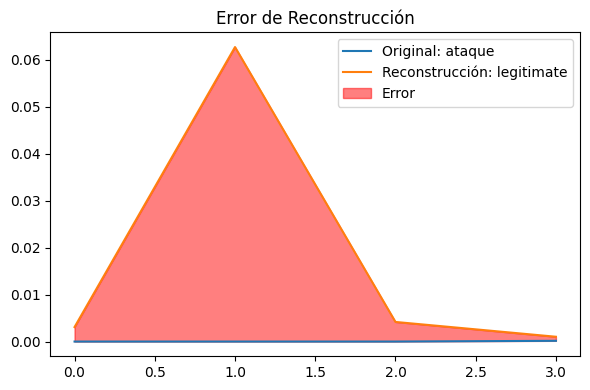

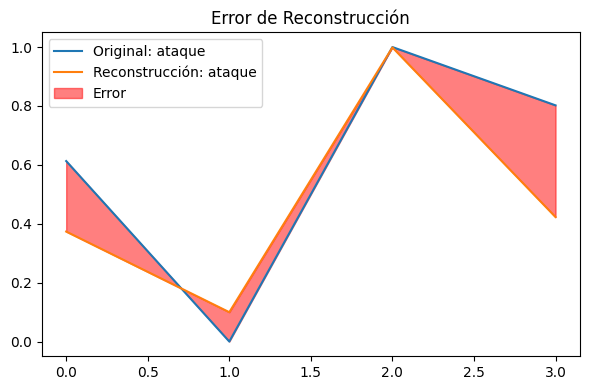

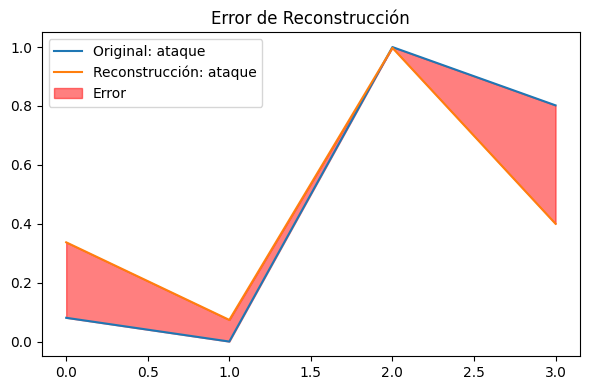

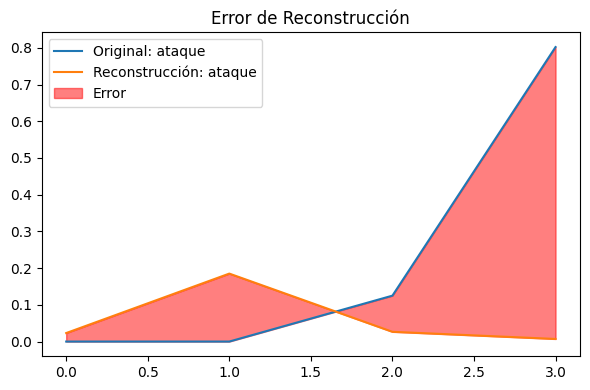

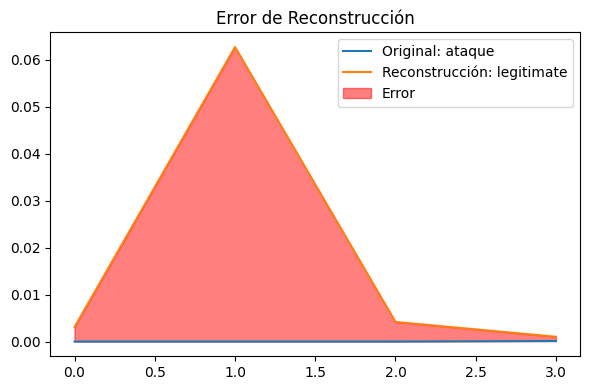

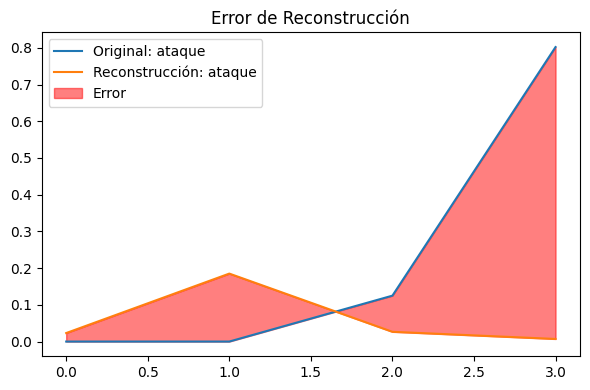

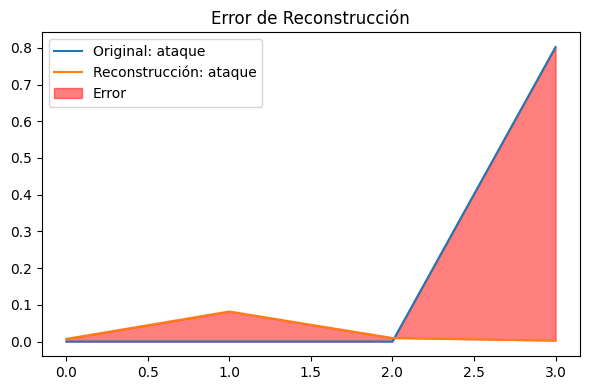

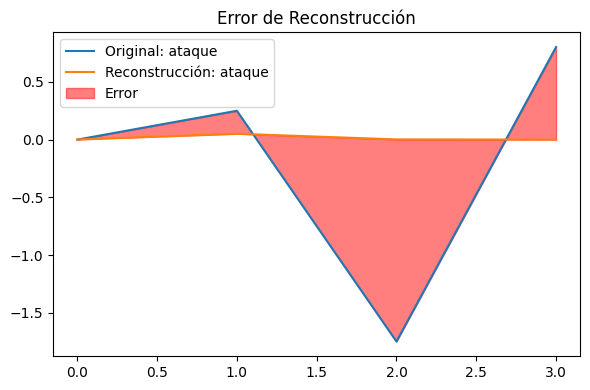

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_original_vs_reconstruction_with_error(original, reconstruction, sample_index):
    plt.figure(figsize=(6, 4))
    
    # Calcular el error entre la entrada original y la reconstrucción
    error = np.abs(original - reconstruction)
    
    plt.title("Error de Reconstrucción")
    plt.plot(original[0], label="Original: " + etiquetas_reales[sample_index])
    plt.plot(reconstruction[0], label="Reconstrucción: " + etiquetas_predichas[sample_index])
    
    # Rellenar el espacio entre la entrada original y la reconstrucción con el color del error
    plt.fill_between(range(len(original[0])), original[0], reconstruction[0], color='red', alpha=0.5, label="Error")
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Tomar las primeras X muestras para graficar
muestras = range(10)

for i in muestras:
    nuevo_dato = dftest[i, :-1].astype(np.float64).reshape(1, -1)
    representacion_latente = autoencoder.layers[0](nuevo_dato)
    reconstruccion = autoencoder.layers[1](representacion_latente)
    
    plot_original_vs_reconstruction_with_error(nuevo_dato, reconstruccion, sample_index=i)

In [25]:
# Calcular las métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(etiquetas_reales, etiquetas_predichas)
precision = precision_score(etiquetas_reales, etiquetas_predichas, pos_label="legitimate") # Especificar cuál es la etiqueta positiva.
recall = recall_score(etiquetas_reales, etiquetas_predichas, pos_label="legitimate")
f1 = f1_score(etiquetas_reales, etiquetas_predichas, pos_label="legitimate")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9989314336598397
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


C:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


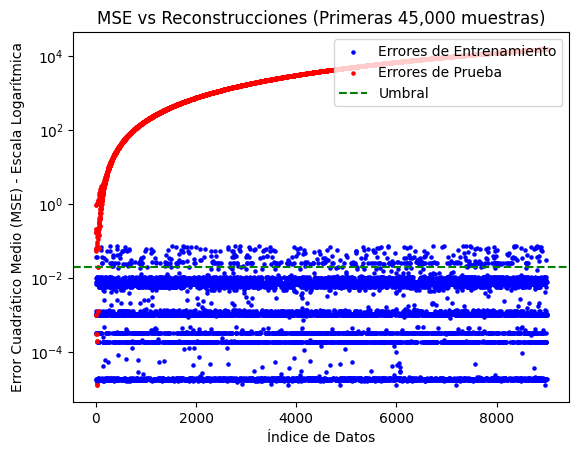

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Número de muestras a mostrar
num_muestras = 9000

# Crear un gráfico de dispersión del MSE versus las reconstrucciones para los errores de entrenamiento
plt.scatter(range(num_muestras), errores_train[:num_muestras], s=5, label='Errores de Entrenamiento', color='blue')

# Crear un gráfico de dispersión del MSE versus las reconstrucciones para los errores de prueba
plt.scatter(range(num_muestras), errores_test[:num_muestras], s=5, label='Errores de Prueba', color='red')

# Dibujar una línea horizontal en el umbral
plt.axhline(y=umbral, color='green', linestyle='--', label='Umbral')

# Cambiar la escala del eje y a logarítmica
plt.yscale('log')

# Etiquetas y título del gráfico
plt.xlabel('Índice de Datos')
plt.ylabel('Error Cuadrático Medio (MSE) - Escala Logarítmica')
plt.title('MSE vs Reconstrucciones (Primeras 45,000 muestras)')

# Mostrar la leyenda
plt.legend(loc='upper right')

# Mostrar el gráfico
plt.show()

In [27]:
# Mapear las etiquetas a valores numéricos
'''etiquetas_reales_numericas = [1 if etiqueta == "ataque" else 0 for etiqueta in etiquetas_reales]
etiquetas_predichas_numericas = [1 if etiqueta == "ataque" else 0 for etiqueta in etiquetas_predichas]

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular el puntaje AUC
auc = roc_auc_score(etiquetas_reales_numericas, etiquetas_predichas_numericas)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(etiquetas_reales_numericas, etiquetas_predichas_numericas)

# Crear la gráfica de la curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar la gráfica
plt.show()'''

'etiquetas_reales_numericas = [1 if etiqueta == "ataque" else 0 for etiqueta in etiquetas_reales]\netiquetas_predichas_numericas = [1 if etiqueta == "ataque" else 0 for etiqueta in etiquetas_predichas]\n\nfrom sklearn.metrics import roc_curve, roc_auc_score\nimport matplotlib.pyplot as plt\n\n# Calcular el puntaje AUC\nauc = roc_auc_score(etiquetas_reales_numericas, etiquetas_predichas_numericas)\n\n# Calcular la curva ROC\nfpr, tpr, thresholds = roc_curve(etiquetas_reales_numericas, etiquetas_predichas_numericas)\n\n# Crear la gráfica de la curva ROC\nplt.figure(figsize=(7, 5))\nplt.plot(fpr, tpr, linewidth=2, label=f\'AUC = {auc:.2f}\')\nplt.plot([0, 1], [0, 1], \'r--\')\nplt.xlim([0, 1])\nplt.ylim([0, 1])\nplt.xlabel(\'False Positive Rate (FPR)\')\nplt.ylabel(\'True Positive Rate (TPR)\')\nplt.title(\'Curva ROC\')\nplt.legend(loc=\'lower right\')\n\n# Mostrar la gráfica\nplt.show()'

## Guardar/Cargar modelo TensorFlow

In [28]:
export_dir = 'saved_model/model'
autoencoder.save(export_dir)
model = tf.keras.models.load_model(export_dir)

INFO:tensorflow:Assets written to: saved_model/model\assets


INFO:tensorflow:Assets written to: saved_model/model\assets


In [29]:
import os

def obtener_tamano_carpeta(ruta_carpeta):
    return sum(os.path.getsize(os.path.join(ruta, archivo))
               for ruta, _, archivos in os.walk(ruta_carpeta) for archivo in archivos)

tf_model_size = obtener_tamano_carpeta(export_dir)
print(tf_model_size)

232206


## Convertir modelo TensorFlow a TensorFlow Lite

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Usuario\AppData\Local\Temp\tmphm6bwn0t\assets


INFO:tensorflow:Assets written to: C:\Users\Usuario\AppData\Local\Temp\tmphm6bwn0t\assets


In [31]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_size = tflite_model_file.write_bytes(tflite_model)
print(tflite_model_size)

9748


# Evaluar modelo TFLite

## Cargar el modelo TFLite

In [32]:
import tensorflow as tf

# Carga el modelo TFLite desde el archivo
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [33]:
# Obtiene los detalles de entrada y salida del modelo TFLite
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Evaluar el modelo TFLite

In [34]:
# Función para detectar anomalías
def detectar_anomalias(nuevo_dato):
    interpreter.set_tensor(input_details[0]['index'], nuevo_dato)
    interpreter.invoke() # Realiza la inferencia
    reconstruccion = interpreter.get_tensor(output_details[0]['index'])
    error = np.mean(np.square(reconstruccion - nuevo_dato))

    if error > umbral:
        return ataque_
    else:
        return "legitimate"

# Crear listas para almacenar las etiquetas reales y predichas
etiquetas_reales = []
etiquetas_predichas = []

# Prueba con nuevos datos
for i in range(len(dftest)):
    nuevo_dato = dftest[i, :-1].astype(np.float32).reshape(1, -1)  # Usar FLOAT32
    etiqueta_predicha = detectar_anomalias(nuevo_dato)
    etiqueta = dftest[i, -1]

    # Agregar las etiquetas reales y predichas a las listas
    etiquetas_reales.append(etiqueta)
    etiquetas_predichas.append(etiqueta_predicha)

In [35]:
# Calcular las métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(etiquetas_reales, etiquetas_predichas)
precision = precision_score(etiquetas_reales, etiquetas_predichas, pos_label="ataque") # Especificar cuál es la etiqueta positiva.
recall = recall_score(etiquetas_reales, etiquetas_predichas, pos_label="ataque")
f1 = f1_score(etiquetas_reales, etiquetas_predichas, pos_label="ataque")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9989314336598397
Precision: 1.0
Recall: 0.9989314336598397
F1 Score: 0.9994654312188168
